![title](truveris_logo.png) 
![title](data_incubator.png)


**Holt-Winters single exponential smoothing. No trend or seasonality.** 

$$s_{i} = \alpha x_{i} + (1-\alpha)s_{i-1} \textrm{, with }0\leq \alpha \leq 1$$

- $x_{i}$ is the actual value at time $i$.
- $\alpha$ is the mixing parameter. How much new vs. old information is used. 
- $s_{i}$ is the smoothed value at time i.
- $s_{i} = \alpha\sum_{j=0}^{i} (1-\alpha)^{j}x_{i-j}$

To forecast beyond the last data point: $x_{i+h} = s_{i}$

**Holt-Winters double exponential smoothing. With trend.**

$$s_{i} = \alpha x_{i} + (1-\alpha)(s_{i-1} + t_{i-1})$$
$$t_{i} = \beta (s_{i} - s_{i-1}) + (1-\beta)t_{i-1}$$

- $t_{i}$ is the trend at time $i$. It is the difference between subsequent values in the series. 
- $\beta$ is a mixing parameter for the trend. How much new vs. old trend information to include.

To forecast beyond the last data point: $x_{i+h} = s_{i} + h t_{i}$

**Holt-Winters triple exponential smoothing. With trend and seasonality.**

$$s_{i} = \alpha (x_{i} - p_{i-k}) + (1-\alpha)(s_{i-1}+t_{i-1})$$
$$t_{i} = \beta (s_{i} - s_{i-1}) + (1-\beta)t_{i-1}$$
$$p_{i} = \gamma (x_{i} - s_{i}) + (1-\gamma)p_{i-k}$$

- $k$ is the length of the period. 
- $\gamma$ is a mixing parameter for the seasonality. 
- $s_{i}$ and $t_{i}$ are to be thought of as 'doubly-smoothed' values, without taking seasonality into account. 
- $p_{i}$ is the seasonal part. 

To forecast beyond the last data point: $x_{i+h} = s_{i} + h t_{i} + p_{i+h-k}$

**Python implementation of Holt-Winters.**

<div align="center">
<a href="http://gist.github.com/andrequeiroz/5888967">http://gist.github.com/andrequeiroz/5888967</a>
</div>

- Double exponential smoothing:
**linear(x, fc, alpha=None, beta=None)**

- Triple exponential smoothing additive:
**additive(x, m, fc, alpha=None, beta=None, gamma=None)**

- Triple exponential smoothing multiplicative:
**multiplicative(x, m, fc, alpha=None, beta=None, gamma=None)**

In [1]:
import csv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from datetime import datetime as dt
import holtwinters as hw
from math import sqrt
from sklearn import linear_model
import numpy as np
from operator import add
import sklearn 

EXAMPLE 1:

Forecasting the percent of uninsured people in the nation using Holt-Winters double exponential smoothing. 

In [2]:
# Import the quarterly uninsured data into a dataframe. 
with open('uninsured_time_series.csv', 'rU') as f:
    reader = csv.reader(f)
    col_names = reader.next()
    rows = [(dt.strptime(row[0], '%y-%b'), float(row[1])) for row in reader]

unins_df = pd.DataFrame(rows, columns=col_names)
raw_ls = list(unins_df['uninsured_proportion'])

0.406583498024 1.0
0.00719580852135 0.0579528203062


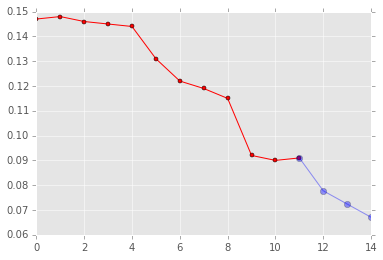

In [3]:
# Optimized parameters. 
hw_fc, alpha, beta, rmse = hw.linear(raw_ls, 3)

print alpha, beta
print rmse, rmse/np.mean(raw_ls)

plt.plot(raw_ls, color='red', marker='o', markersize=4)
plt.plot([None]*(len(raw_ls)-1) + [raw_ls[-1]] +hw_fc, color='blue', marker='o', alpha=.4)

0.8 0.85
0.00831175581559 0.0669403152934


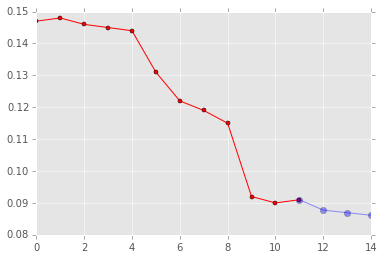

In [4]:
# Tuning parameters by hand. 
a, b = (.8, .85)
hw_fc, alpha, beta, rmse = hw.linear(raw_ls, 3, a, b)

print alpha, beta
print rmse, rmse/np.mean(raw_ls)

plt.plot(raw_ls, color='red', marker='o', markersize=4)
plt.plot([None]*(len(raw_ls)-1) + [raw_ls[-1]] + hw_fc, color='blue', marker='o', alpha=.4)

EXAMPLE 2:

Forecasting the national average cost of a brand drug using Holt-Winters triple exponential smoothing. 

In [5]:
# Import data. 
with open('monthly_ndi_official.csv', 'rb') as f:
    reader= csv.reader(f)
    col_names = reader.next()
    rows = [[dt.strptime(row[0], '%m/%d/%y')] + map(float, row[1:]) for row in reader]

ndi_df = pd.DataFrame(rows, columns = col_names)

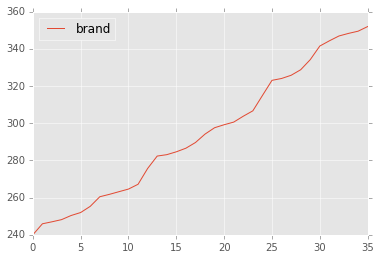

In [6]:
ts_df = ndi_df[['date', 'brand']].copy()
ts_df.plot()

0.0113381210607 -0.00163717122727 0.994705050078


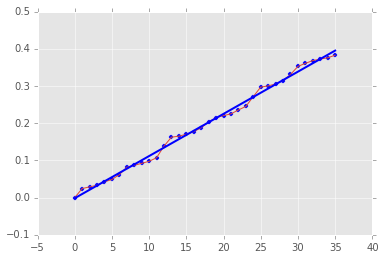

In [7]:
ts_df['index'] = ts_df['brand']/ts_df.loc[0, 'brand']
ts_df['log_index'] = np.log(ts_df['index'])

X_train = [[x] for x in ts_df.index]
y_train = ts_df['log_index']

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

m = regr.coef_[0]
b = regr.intercept_

print m, b, regr.score(X_train, y_train)

plt.scatter(X_train, y_train)
plt.plot(X_train, y_train)
plt.plot(X_train, regr.predict(X_train), color='blue', linewidth=2)

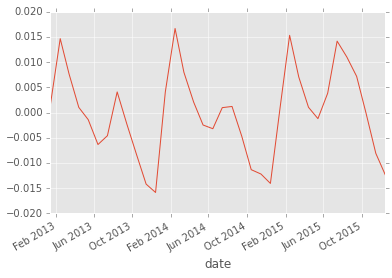

In [8]:
ts_df['index_log_model'] = regr.predict(X_train)
ts_df['index_log_resid'] = ts_df['log_index'] - ts_df['index_log_model']

temp_df = ts_df.copy()
temp_df.index = temp_df['date']
temp_df['index_log_resid'].plot()

resids = temp_df['index_log_resid']

alpha is 0.0, beta is 0.0, gamma is 1.0.
rmse is 0.00182461126928.


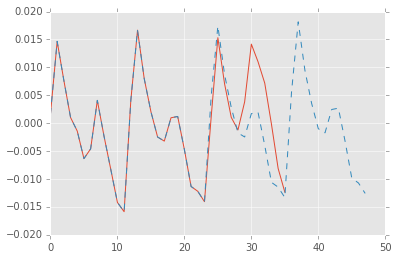

In [9]:
overlap = 12
hw_forecast = hw.additive(list(resids[:-1*overlap]), 12, 12+overlap)

print "alpha is %s, beta is %s, gamma is %s." %hw_forecast[1:4]
print "rmse is %s." %hw_forecast[4]

temp_ls = list(resids[:-1*overlap]) + hw_forecast[0]

plt.plot(list(resids[:]))
plt.plot(temp_ls, '--')

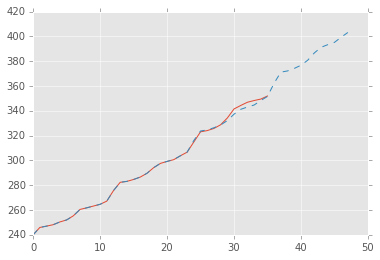

In [10]:
line_ls = [m*x+b for x in range(len(temp_ls))]
new_log_model_ls = [x for x in map(add, line_ls, temp_ls)]
fc_ls = ts_df.loc[0, 'brand']*np.exp(new_log_model_ls)
plt.plot(ts_df['brand'])
plt.plot(fc_ls, '--')

In [11]:
rmse = sklearn.metrics.mean_squared_error(ts_df.loc[24:36, 'brand'], fc_ls[24:36])**0.5
print rmse, rmse/340.

2.30578238915 0.00678171290926
